# An Example

This example demonstrates the process of loading dataset, training, evaluation and prediction, using an exemplary dataset. The dataset contains 500 graphene structures that are generated using Rebo potential. The code has been run with Tensorflow 2.6.

In [1]:
import atomdnn

# 'float64' is used for reading data and train by default
atomdnn.data_type = 'float64'

# force and stress are evaluated by default, 
# if one only need to compute potential energy, then set compute_force to false
atomdnn.compute_force = True

# default value is for converting ev/A^3 to GPa
# note that: the predicted positive stress means tension and negative stress means compression
stress_unit_convert = 160.2176 

import numpy as np
import tensorflow as tf
from atomdnn import data
from atomdnn import network
from atomdnn.data import Data
from atomdnn.data import *
from atomdnn.network import Network

In [2]:
# load tensorflow dataset, for Tensorflow version lower than 2.6, need to specify element_spec.
# The process of reading data and creating dataset is discussed in 'Data pipeline' section.

dataset = tf.data.experimental.load('example_tfdataset')

2021-10-18 20:31:02.889041: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9673 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:19:00.0, compute capability: 7.5
2021-10-18 20:31:02.890232: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9673 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5


In [3]:
# split the data to training, validation and testing sets

train_dataset, val_dataset, test_dataset = split_dataset(dataset,0.7,0.2,0.1,shuffle=True)

Traning data: 350 images
Validation data: 100 images
Test data: 50 images


In [4]:
# Build the network
# See section 'Training' for detailed description on Network object.

elements = ['C']
act_fun = 'relu' # activation function
nfp = get_fingerprints_num(dataset) # number of fingerprints (or descriptors)
arch = [30,30] # NN layers

model = Network(elements = elements,\
                num_fingerprints = nfp,\
                arch = arch,\
                activation_function = act_fun)

In [5]:
# Train the model 

opt = 'Adam' # optimizer
loss_fun = 'rmse' # loss function
scaling = 'std' # scaling the traning data with standardization
lr = 0.02 # learning rate
loss_weights = {'pe' : 1, 'force' : 1, 'stress': 0.1} # the weights in loss function

model.train(train_dataset, val_dataset, \
            optimizer=opt, \
            loss_fun = loss_fun, \
            batch_size=30, \
            lr=lr, \
            epochs=30, \
            scaling=scaling, \
            loss_weights=loss_weights, \
            compute_all_loss=True, \
            shuffle=True, \
            append_loss=True)

2021-10-18 20:31:03.029728: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Forces are used for training.
Stresses are used for training.
Scaling factors are computed using training dataset.
Training dataset are standardized.
Validation dataset are standardized.
Training dataset will be shuffled during training.

===> Epoch 1/30 - 3.006s/epoch
     training_loss    - pe_loss: 134.844 - force_loss: 1004.789 - stress_loss: 33103.327 - total_loss: 4449.965
     validation_loss  - pe_loss: 132.699 - force_loss: 870.057 - stress_loss: 35755.177 - total_loss: 4578.274

===> Epoch 2/30 - 0.980s/epoch
     training_loss    - pe_loss: 60.050 - force_loss: 618.052 - stress_loss: 19700.988 - total_loss: 2648.201
     validation_loss  - pe_loss: 37.173 - force_loss: 530.598 - stress_loss: 12692.530 - total_loss: 1837.024

===> Epoch 3/30 - 0.987s/epoch
     training_loss    - pe_loss: 54.029 - force_loss: 498.096 - stress_loss: 12022.176 - total_loss: 1754.343
     validation_loss  - pe_loss: 43.944 - force_loss: 425.128 - stress_loss: 8721.768 - total_loss: 1341.249

===

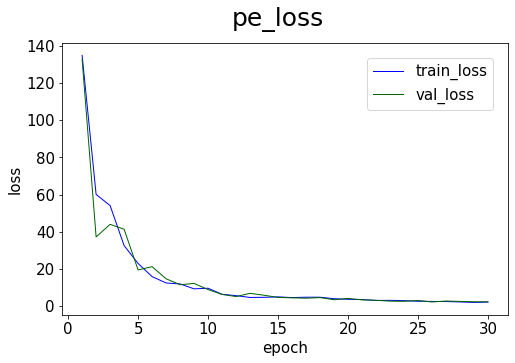

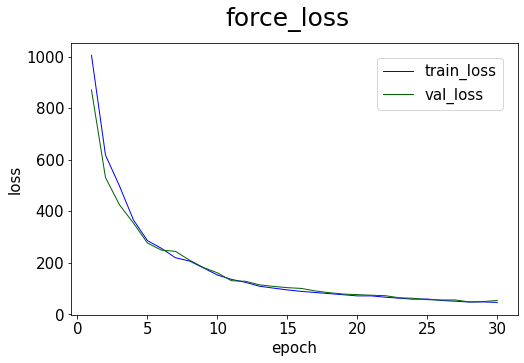

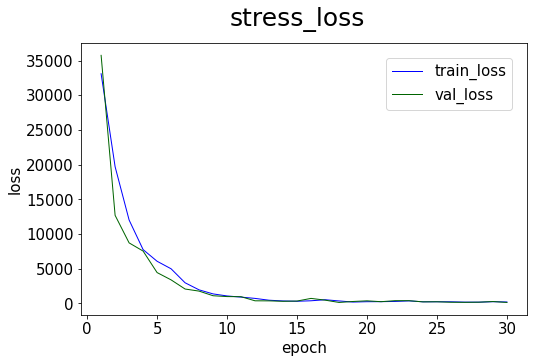

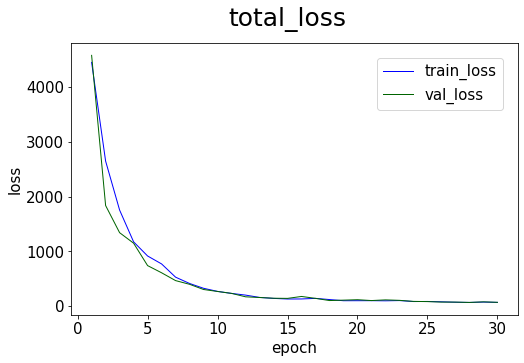

In [6]:
# plot the training loss

model.plot_loss(start_epoch=1)

In [7]:
# Evaluate using the first 5 data in test dataset

model.evaluate(test_dataset.take(5),return_prediction=False)

Evaluation loss is:
        pe_loss:       2.8502e+00
     force_loss:       4.2136e+01
    stress_loss:       2.1507e+02
     total_loss:       6.6493e+01
The total loss is computed using the loss weights - pe: 1.00 - force: 1.00 - stress: 0.10


In [8]:
# prediction using the first 5 data in test dataset

input_dict = get_input_dict(test_dataset.take(5))
model.predict(input_dict)

{'pe': array([-33.64963295, -27.8340001 , -26.66213381, -26.70762979,
        -26.77452191]),
 'force': array([[[ 4.50301558e+01,  6.06689602e+01, -3.52306638e+01],
         [-3.15401659e+01, -7.05534273e+00, -1.50324959e+01],
         [-2.95257309e+01, -3.73839587e+01,  3.63325884e+01],
         [ 1.60357403e+01, -1.62296587e+01,  1.39305712e+01]],
 
        [[-1.37375488e+01, -5.44136970e+00,  1.38023897e+01],
         [-4.40907017e+01, -3.89830207e+00,  8.54129938e+00],
         [ 2.38128318e+01,  9.51667524e+00, -2.70369110e+01],
         [ 3.40154190e+01, -1.77003087e-01,  4.69322193e+00]],
 
        [[ 3.00973826e+01,  1.40044544e+01,  9.59020560e+01],
         [-3.60568175e+01, -3.29374687e+01, -4.03512222e+01],
         [ 4.26791480e+01,  3.83621441e+01,  1.46463503e+02],
         [-3.67197135e+01, -1.94291288e+01, -2.02014337e+02]],
 
        [[ 1.32694789e+01, -1.56755587e+01, -5.00440540e+01],
         [-6.33947983e+01,  6.42386199e+01,  2.42734869e+00],
         [ 4.8517853

In [9]:
# save the trained model

descriptor = {'name': 'acsf', 
              'cutoff': 6.5001,
              'etaG2':[0.01,0.025,0.05,0.075,0.1,0.15,0.2,0.3,0.4,0.5,0.6,0.8,1,1.5,2,3,5,10], 
              'etaG4': [0.01], 
              'zeta': [0.08,0.1,0.15,0.2,0.3,0.35,0.5,0.6,0.8,1.,1.5,2.,3.0,4.,5.5,7.0,10.0,25.0,50.0,100.0],
              'lambda': [1.0, -1.0]}

save_dir = 'example.tfdnn'
network.save(model,save_dir,descriptor=descriptor)

2021-10-18 20:31:35.976341: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: example.tfdnn/assets
Network signatures and descriptor are written to example.tfdnn/parameters for LAMMPS simulation.


In [11]:
# Load the saved model for continuous training and prediction

imported_model = network.load(save_dir)

Network has been inflated! self.built: True


In [12]:
# Re-train the model 

loss_weights = {'pe' : 1, 'force' : 1, 'stress': 0.1}

opt = 'Adam'
loss_fun = 'rmse'
scaling = 'std'

model.train(train_dataset, val_dataset, \
            optimizer=opt, \
            loss_fun = loss_fun, \
            batch_size=30, \
            lr=0.02, \
            epochs=5, \
            scaling=scaling, \
            loss_weights=loss_weights, \
            compute_all_loss=True, \
            shuffle=True, \
            append_loss=True)

Forces are used for training.
Stresses are used for training.
Scaling factors are computed using training dataset.
Training dataset are standardized.
Validation dataset are standardized.
Training dataset will be shuffled during training.

===> Epoch 1/5 - 0.967s/epoch
     training_loss    - pe_loss: 9.489 - force_loss: 69.691 - stress_loss: 1656.623 - total_loss: 244.841
     validation_loss  - pe_loss: 9.228 - force_loss: 71.152 - stress_loss: 2252.832 - total_loss: 305.664

===> Epoch 2/5 - 0.948s/epoch
     training_loss    - pe_loss: 6.011 - force_loss: 53.358 - stress_loss: 901.348 - total_loss: 149.503
     validation_loss  - pe_loss: 6.447 - force_loss: 51.585 - stress_loss: 831.016 - total_loss: 141.133

===> Epoch 3/5 - 0.959s/epoch
     training_loss    - pe_loss: 4.921 - force_loss: 48.135 - stress_loss: 650.544 - total_loss: 118.110
     validation_loss  - pe_loss: 3.495 - force_loss: 42.631 - stress_loss: 487.420 - total_loss: 94.868

===> Epoch 4/5 - 0.974s/epoch
     tr

In [13]:
imported_model.evaluate(test_dataset.take(5),return_prediction=False)

Evaluation loss is:
        pe_loss:       2.8502e+00
     force_loss:       4.2136e+01
    stress_loss:       2.1507e+02
     total_loss:       6.6493e+01
The total loss is computed using the loss weights - pe: 1.00 - force: 1.00 - stress: 0.10


In [14]:
input_dict = get_input_dict(test_dataset.take(5))
imported_model.predict(input_dict)

{'pe': array([-33.64963295, -27.8340001 , -26.66213381, -26.70762979,
        -26.77452191]),
 'force': array([[[ 4.50301558e+01,  6.06689602e+01, -3.52306638e+01],
         [-3.15401659e+01, -7.05534273e+00, -1.50324959e+01],
         [-2.95257309e+01, -3.73839587e+01,  3.63325884e+01],
         [ 1.60357403e+01, -1.62296587e+01,  1.39305712e+01]],
 
        [[-1.37375488e+01, -5.44136970e+00,  1.38023897e+01],
         [-4.40907017e+01, -3.89830207e+00,  8.54129938e+00],
         [ 2.38128318e+01,  9.51667524e+00, -2.70369110e+01],
         [ 3.40154190e+01, -1.77003087e-01,  4.69322193e+00]],
 
        [[ 3.00973826e+01,  1.40044544e+01,  9.59020560e+01],
         [-3.60568175e+01, -3.29374687e+01, -4.03512222e+01],
         [ 4.26791480e+01,  3.83621441e+01,  1.46463503e+02],
         [-3.67197135e+01, -1.94291288e+01, -2.02014337e+02]],
 
        [[ 1.32694789e+01, -1.56755587e+01, -5.00440540e+01],
         [-6.33947983e+01,  6.42386199e+01,  2.42734869e+00],
         [ 4.8517853